# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

## Aggregating diverse distance functions

We want to combine different distance metrics operating on subsets of the data to one distance value. As a toy model, assume we want to combine a Laplace and a Normal distance.

In [1]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 
            's1': p['p1'] + 0.1 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

INFO:History:Start <ABCSMC(id=10, start_time=2019-10-07 12:06:03.078438, end_time=None)>
INFO:Epsilon:initial epsilon is 0.8541409750139186
INFO:ABC:t:0 eps:0.8541409750139186
INFO:ABC:t:1 eps:0.49584307992962073
INFO:ABC:t:2 eps:0.2967481521293882
INFO:ABC:t:3 eps:0.1801402117711828
INFO:ABC:t:4 eps:0.11811551667170728
INFO:ABC:t:5 eps:0.06545934195453983
INFO:History:Done <ABCSMC(id=10, start_time=2019-10-07 12:06:03.078438, end_time=2019-10-07 12:06:14.372286)>


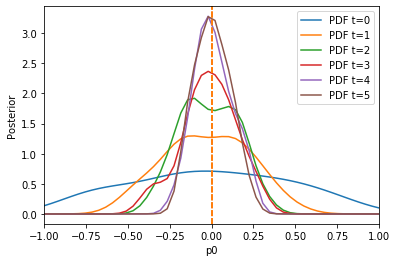

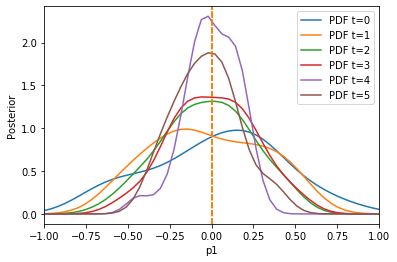

In [2]:
distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

INFO:History:Start <ABCSMC(id=11, start_time=2019-10-07 12:06:15.109933, end_time=None)>
INFO:Epsilon:initial epsilon is 3556.0806766549586
INFO:ABC:t:0 eps:3556.0806766549586
INFO:ABC:t:1 eps:565.9142074369443
INFO:ABC:t:2 eps:93.37286732925875
INFO:ABC:t:3 eps:19.903844024949045
INFO:ABC:t:4 eps:5.883669969742791
INFO:ABC:t:5 eps:1.7909823861665233
INFO:History:Done <ABCSMC(id=11, start_time=2019-10-07 12:06:15.109933, end_time=2019-10-07 12:06:52.652973)>


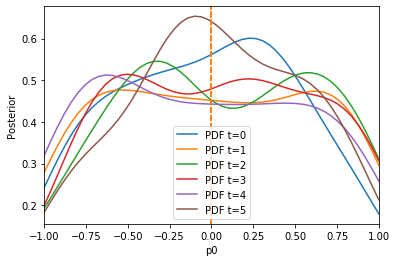

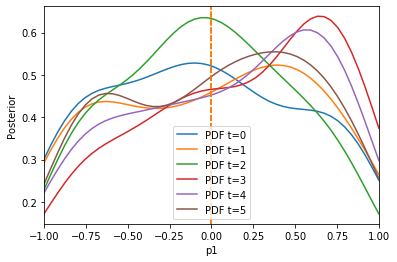

In [3]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 
            's1': p['p1'] + 100 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return (x['s1'] - x_0['s1'])**2

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=6)

# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `pyabc.distance.AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

INFO:History:Start <ABCSMC(id=12, start_time=2019-10-07 12:06:53.320634, end_time=None)>
INFO:Epsilon:initial epsilon is 0.6065701545753189
INFO:ABC:t:0 eps:0.6065701545753189
INFO:ABC:t:1 eps:0.6473137261156832
INFO:ABC:t:2 eps:0.6407943893637535
INFO:ABC:t:3 eps:0.5155646293420847
INFO:ABC:t:4 eps:0.652740841941481
INFO:ABC:t:5 eps:0.683844190695896
INFO:History:Done <ABCSMC(id=12, start_time=2019-10-07 12:06:53.320634, end_time=2019-10-07 12:07:02.618912)>


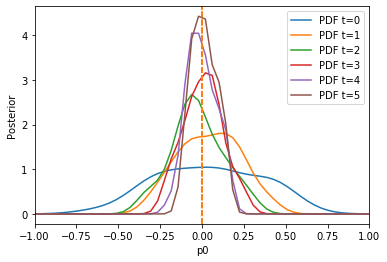

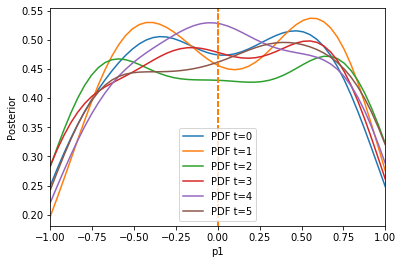

In [4]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=6)

plot(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

INFO:History:Start <ABCSMC(id=13, start_time=2019-10-07 12:07:03.308421, end_time=None)>
INFO:Epsilon:initial epsilon is 0.6375592044632301
INFO:ABC:t:0 eps:0.6375592044632301
INFO:ABC:t:1 eps:0.3956093990332792
INFO:ABC:t:2 eps:0.2112504438216726
INFO:ABC:t:3 eps:0.1339962943775436
INFO:ABC:t:4 eps:0.08513746755818472
INFO:ABC:t:5 eps:0.05168796324293466
INFO:History:Done <ABCSMC(id=13, start_time=2019-10-07 12:07:03.308421, end_time=2019-10-07 12:07:08.312068)>


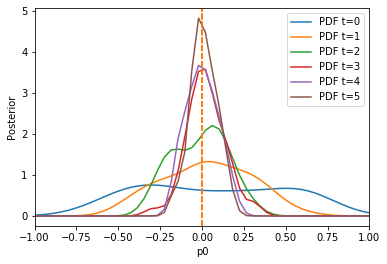

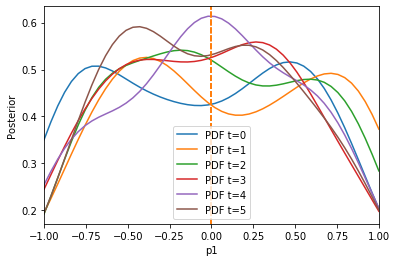

In [5]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.AdaptiveAggregatedDistance(
    [distance0, distance1], adaptive=False)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=6)

plot(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time. Note that one can also specify other scale functions, by passing ``AdaptiveAggregatedDistance(distances, scale_function)``, e.g. ``pyabc.distance.mean[/median/span]``.

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

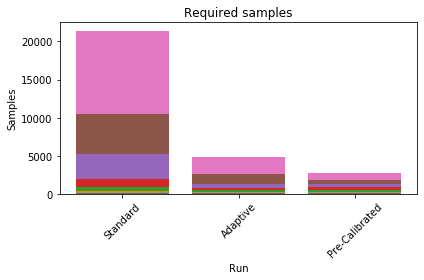

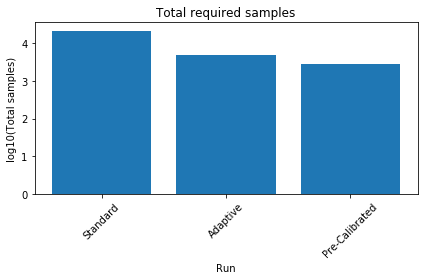

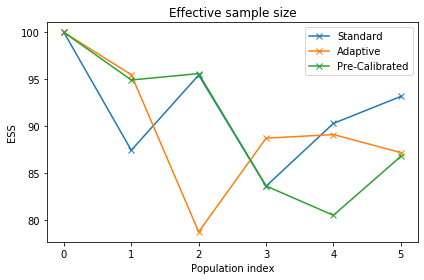

In [6]:
histories = [history1, history2, history3]
labels = ["Standard", "Adaptive", "Pre-Calibrated"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10', rotation=45)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)